In [1]:
import cv2 as cv
import os
import IPython.display as ipd

import json

import numpy as np

import keras

from keras.preprocessing import image as kimage
from keras.applications import resnet_v2
from keras.models import Model
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Imports for face alignment
# How to install:
#    pip install imutils
#    conda install -c conda-forge dlib  
import imutils
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import dlib

In [3]:
import utils_2d

## Dlib Detector and Predictor

In [4]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
fa = FaceAligner(predictor, desiredFaceWidth=224)

Good models:

- 8, more or less
- 13
- 14
- 17
- 18/19?
- 20 (model trained on heavily resized pictures)
- 21? (model trained also on pictures where Khaled is not wearing glasses, needs further testing)

In [5]:
model_number = 21
model, labels, preprocess_fun = utils_2d.load_model(21)

In [6]:
# check
preprocess_fun(255)

1.0

In [7]:
labels

array(['alessandro', 'alinda', 'cami', 'gian', 'khaled', 'mamma', 'papi'],
      dtype='<U10')

# Test with webcam

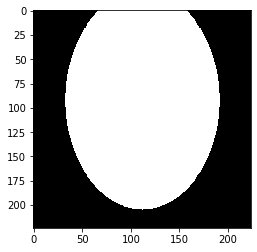

In [8]:
mask = utils_2d.create_mask()
plt.imshow(mask, cmap="gray")
plt.show()

In [9]:
def test_model(model, labels, mask, preprocess_fun = preprocess_fun, model_number = model_number,
               basedir = "test_pictures", new_width=200, mirror=True, more_space=10, threshold = 50):
    
    if not os.path.isdir(basedir):
        print(f"Created new directory {basedir}")
        os.makedirs(basedir)

    current_images = [img for img in os.listdir(basedir) if (img.endswith(".png") and img.startswith(str(model_number)))]
    
    filename_format = f"{basedir}/{model_number}_"+"{}.png"
    
    i = utils_2d.find_last_filename_id(current_images)
    
    labels = np.array(labels)
    cap = cv.VideoCapture(0)
    while(True):
        
        r, frame = cap.read()
        if mirror:
            frame = cv.flip(frame, 1)
        
        try:
            frame = add_box(frame, model, labels, mask, preprocess_fun, new_width, more_space, threshold)
            cv.imshow('Video', frame)
            
        except Exception as e:
            print(e)
            pass
    
        if cv.waitKey(1) & 0xFF == ord('s'):
            
            i += 1
            filename = filename_format.format(i)
            cv.imwrite(filename, frame)
            ipd.clear_output(wait=True)
            print(f"Saved {filename}".replace("//", "/"))
                
        
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
                        
    cap.release()
    cv.destroyAllWindows()

In [10]:
def add_box(img, model, labels, mask, preprocess_fun = preprocess_fun, new_width=200, more_space=10, threshold=50):
    m = more_space
    
    fontColors = [(0,0,255), (255,160,0), (0,255,0),
                  (0,255, 255), (193,182,255)]
    fontScale              = 2
    lineType               = 2
    font                   = cv.FONT_HERSHEY_PLAIN
    
    if img is not None:
        
        face = 0
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        og_width = gray.shape[1]
        scaler = og_width/new_width
        gray = imutils.resize(gray, width = new_width)

        faces = detector(gray, 2) # check: what is the 2
        
        for rect in faces:
            
            
            (x, y, w, h) = rect_to_bb(rect)
            
            gray2 = utils_2d.preprocess_face(gray, mask, fa, rect)
            
            gray2 = preprocess_fun(gray2)
            
            # # uncomment to test if the preprocessing is working
            # plt.imshow(gray2, cmap="gray")
            # plt.show()
            
            # rescale box
            (x, y, w, h) = (np.array((x,y,w,h))*scaler).astype(int)
                
            # make prediction
            pred = model.predict(gray2[np.newaxis,:,:, np.newaxis])[0]            
            text = labels[np.argmax(pred)]
            
            # no prediction if model's confidence below threshold
            conf = pred[np.argmax(pred)]*100
            if conf < threshold:
                text = "?"
                
            # add box and text
            topLeftCornerOfText = (x-m,y-m-5)
            bottomLeftCornerOfText = (x-m,y+h+35)    
            fontColor              = fontColors[face]
            face += 1
                  
            cv.rectangle(img,(x-m,y-m),(x+w+m,y+h+m),fontColor,2)
            cv.putText(img, f"{text}", topLeftCornerOfText,
                       font, fontScale, fontColor, lineType)
            cv.putText(img, f"{conf:.2f}%", bottomLeftCornerOfText,
                       font, fontScale, fontColor, lineType)
                    
    return img

`new_width` is the width of the resized image passed to the dlib detector.

Smaller values mean smoother webcam preview, but prediction is slightly affected.

OK values are between 150/250 depending on how far the face is from the webcam

In [11]:
# spam q to exit, the save function makes exiting lag a bit
n = 2
basedir=f"test_pictures/{n}/"
test_model(model,labels, mask, new_width=200, threshold=50, basedir=basedir)

## Test single shot

In [12]:
def test_model_single_shot(model,labels, mask, preprocess_fun = preprocess_fun,
                           new_width=200, threshold=50, mirror = True):
    
    cap = cv.VideoCapture(0)
    result, img = cap.read()
    
    if mirror:
            img = cv.flip(img, 1)
    
    cap.release()
    
    img2 = add_box(img, model, labels, mask, preprocess_fun, new_width, threshold=threshold)[:,:,::-1]
    
    plt.figure(figsize=(14,7))
    plt.imshow(img2)
    plt.show()
    
    return img2

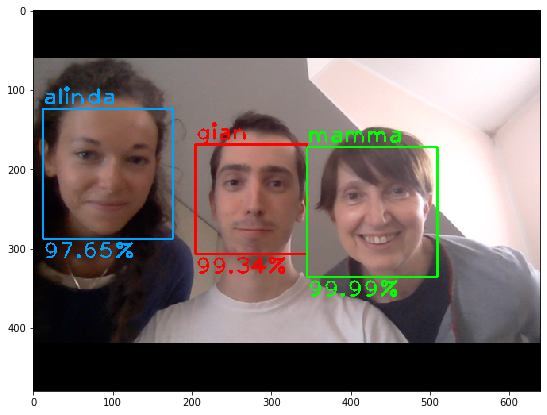

In [30]:
img = test_model_single_shot(model, labels, mask, threshold=50)

# Test picture

In [31]:
model_filename = 'C:/Users/gianc/Anaconda3/envs/dsim/Lib/site-packages/cv2/data/haarcascade_frontalface_default.xml'
face_detector = cv.CascadeClassifier(model_filename)

In [32]:
def test_picture(filename, model, labels, mask, preprocess_fun = preprocess_fun, new_width=500,
                 threshold = 50, resize = None, cut = False):
    # might make sense to test on some pictures not used during training

    img = cv.imread(filename)
    
    if resize is not None:
        img = imutils.resize(img, resize)
    img2 = add_box(img, model, labels, mask, preprocess_fun, new_width, threshold=threshold)[:,:,::-1]
    
    plt.figure(figsize=(14,7))
    plt.imshow(img2)
    plt.show()
    
    return img2

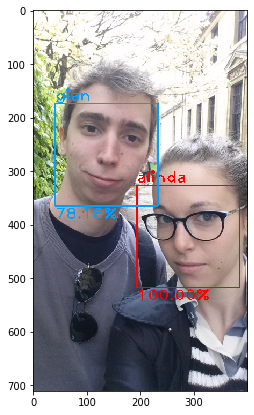

In [44]:
img = test_picture("misc_pictures/13.jpg", model, labels, mask, resize = 400, new_width=450)

# Test Directories

In [45]:
def test_directory(name, basedir, labels, model, mask, preprocess_fun=preprocess_fun, new_width=200):
    # might make sense to test on some pictures not used during training
    
    srcdir = basedir+"/"+name
    counts={}
    for label in labels:
        counts[label] = 0
    total = 1
    
    for file in os.listdir(srcdir):
        img = cv.imread(srcdir+"/"+file)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        gray = imutils.resize(gray, new_width)
        faces = detector(gray, 2)
        if len(faces)>0:
            rect = faces[0]
            gray2 = fa.align(gray, gray, rect)
        else:
            gray2 = cv.resize(gray, (224, 224))
        gray2 = cv.equalizeHist(gray2)
        gray2[~mask] = 0
        gray2 = preprocess_fun(gray2)
        
        pred = model.predict(gray2[np.newaxis,:,:, np.newaxis])[0]            
        text = labels[np.argmax(pred)]
        
        counts[text] += 1
        ipd.clear_output(wait=True)
        for i in counts.keys():
            print("{}: {}".format(i, counts[i]))
        print("\ntotal: ", total)
        print("accuracy: ", counts[name]/total)
        total += 1

This also gives an idea of the difference in speed and accuracy when resizing the picture before detecting the face with dlib.

(Note that the following is resizing a picture that is already cropped and with a face, while in the above tests it is resizing the picture from the webcam).

(pictures in "test_pictures" were not used during training)

In [46]:
%%time
test_directory("alinda", "test_pictures", labels, model, mask, new_width=20)

alessandro: 0
alinda: 1399
cami: 0
gian: 0
khaled: 158
mamma: 8
papi: 24

total:  1589
accuracy:  0.880427942101951
Wall time: 1min 33s


In [47]:
%%time
test_directory("alinda", "test_pictures", labels, model, mask, new_width=30)

alessandro: 0
alinda: 1499
cami: 0
gian: 20
khaled: 21
mamma: 12
papi: 37

total:  1589
accuracy:  0.9433606041535557
Wall time: 1min 48s


In [48]:
%%time
test_directory("alinda", "test_pictures", labels, model, mask, new_width=50)

alessandro: 0
alinda: 1495
cami: 0
gian: 65
khaled: 5
mamma: 10
papi: 14

total:  1589
accuracy:  0.9408432976714916
Wall time: 2min 5s


In [49]:
%%time
test_directory("alinda", "test_pictures", labels, model, mask, new_width=80)

alessandro: 7
alinda: 1458
cami: 0
gian: 93
khaled: 6
mamma: 11
papi: 14

total:  1589
accuracy:  0.9175582127123977
Wall time: 2min 33s
